In [2]:
%cd ..

/home/jupyter-tim/ba-tim


In [35]:
from drlqap.taskgenerators import RandomWeightsTaskGenerator
import scipy.optimize
from drlqap.simplesolver import solve_qap_backtracking, solve_qap_maxgreedy, solve_qap_faq, solve_random
from drlqap.gurobi import solve_qap_gurobi
import numpy as np
from drlqap.qap import QAP
from drlqap.qapenv import QAPReductionEnv
from drlqap.evaltools import load_checkpoints
from pathlib import Path
import random
import matplotlib.pyplot as plt
import torch

# Simple reward distribution plots

In [270]:
def random_policy(env):
    return (0,0) # Decided by fair dice roll (assumes random qap)

def reward_distribution(qap, policy):
    env = QAPReductionEnv(qap)
    rewards = []
    while not env.done:
        rewards.append(env.step(policy(env)))
    return rewards

In [256]:
generator = RandomWeightsTaskGenerator(16)

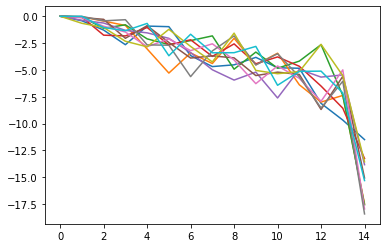

In [257]:
for i in range(10):
    qap = generator.sample()
    plt.plot(reward_distribution(qap, random_policy))

In [293]:
distributions = np.array([reward_distribution(generator.sample(), random_policy) for i in range(500)])
means = distributions.mean(axis=0)
variances = distributions.var(axis=0)

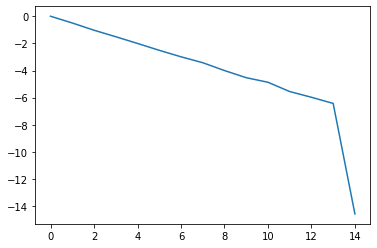

In [294]:
plt.plot(means)

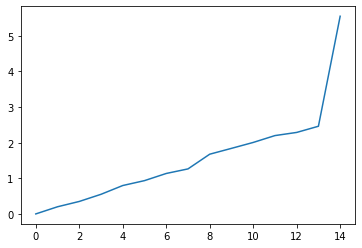

In [295]:
plt.plot(variances)

# Reward span between among possible actions

In [296]:
def reward_span(qap, policy):
    env = QAPReductionEnv(qap)
    out = []
    lower = []
    upper = []
    while not env.done:
        qap = env.get_state()
        l = torch.min(qap.linear_costs).item()
        u = torch.max(qap.linear_costs).item()
        out.append(u-l) # Reward is given by linear costs
        lower.append(l)
        upper.append(u)
        env.step(policy(env))
    out.append(0)
    lower.append(qap.linear_costs[0,0])
    upper.append(qap.linear_costs[0,0])
    return out, lower, upper

In [308]:
reward_spans, reward_lower, reward_upper = np.array([reward_span(generator.sample(), simple_policy) for i in range(500)]).transpose(1,0,2)

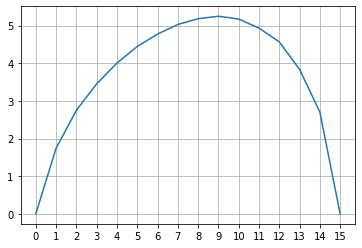

In [309]:
xs = range(reward_spans.shape[1])
plt.xticks(xs)
plt.plot(reward_spans.mean(axis=0))
plt.grid()

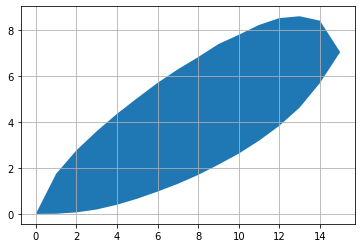

In [267]:
plt.fill_between(xs, reward_lower.mean(axis=0), reward_upper.mean(axis=0))
plt.grid()

# Agent expected reward

In [272]:
dqn_medium_agents = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1'))
dqn_small_agents = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1'))
dqn_inc_agents = load_checkpoints(Path('runs/dqn_bi_increasing/lr5e-4_s1'))

runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_3000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_4000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_5000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_6000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_7000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_8000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_9000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_end.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_smal

In [38]:
def expected_reward_distribution(agent, qap):
    with torch.no_grad():
        env = QAPReductionEnv(qap)
        rewards = []
        expected_rewards = []
        last_expected_value = None
        while not env.done:
            expected_value = agent.target_net(env.get_state()).flatten().max().item()
            if last_expected_value:
                expected_rewards.append(last_expected_value - expected_value)
            state = env.get_state()
            rewards.append(env.step((0,0)))
            last_expected_value = expected_value
        expected_rewards.append(last_expected_value)
        
        return expected_rewards, rewards

In [98]:
generator = RandomWeightsTaskGenerator(32)
qaps = [generator.sample() for i in range(100)]

In [99]:
def compute_prediction_stats(agent):
    bias = []
    error = []
    for qap in qaps:
        expectation, reality = expected_reward_distribution(agent, qap)
        bias.append(np.array(expectation) - reality)
        error.append(np.square(np.array(expectation) - reality))
    return error, bias

In [100]:
md_error, md_bias = compute_prediction_stats(dqn_medium_agents[-1])

In [101]:
sm_error, sm_bias = compute_prediction_stats(dqn_small_agents[-1])

In [102]:
inc_error, inc_bias = compute_prediction_stats(dqn_inc_agents[-1])

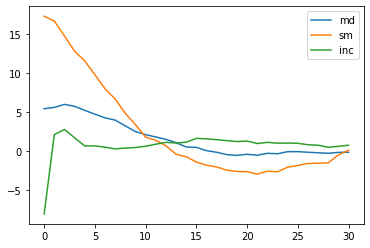

In [103]:
plt.plot(np.array(md_bias).mean(axis=0), label="md")
plt.plot(np.array(sm_bias).mean(axis=0), label="sm")
plt.plot(np.array(inc_bias).mean(axis=0), label="inc")
plt.legend()

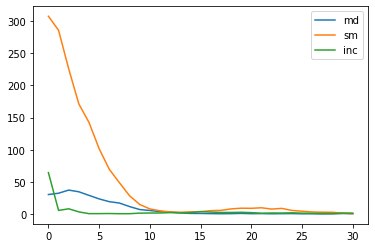

In [106]:
plt.plot(np.array(md_error).mean(axis=0), label="md")
plt.plot(np.array(sm_error).mean(axis=0), label="sm")
plt.plot(np.array(inc_error).mean(axis=0), label="inc")
plt.legend()
#plt.yscale('log')

# Reward distribution with agent policy

In [287]:
from drlqap.utils import argmax2d
def get_agent_policy(agent):
    return lambda env: argmax2d(agent.policy_net(env.get_state()))

In [288]:
dqn_policy = get_agent_policy(dqn_medium_agents[-1])
agent_distributions = np.array([reward_distribution(generator.sample(), dqn_policy) for i in range(100)])
agent_means = agent_distributions.mean(axis=0)
agent_variances = agent_distributions.var(axis=0)

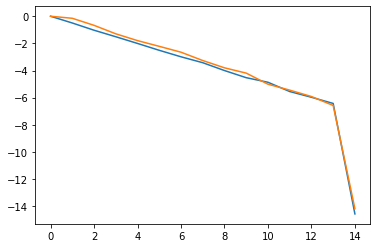

In [302]:
plt.plot(means)
plt.plot(agent_means)

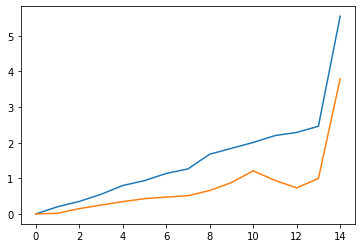

In [301]:
plt.plot(variances)
plt.plot(agent_variances)

In [291]:
agent_reward_spans, agent_reward_lower, agent_reward_upper = np.array([reward_span(generator.sample(), dqn_policy) for i in range(500)]).transpose(1,0,2)

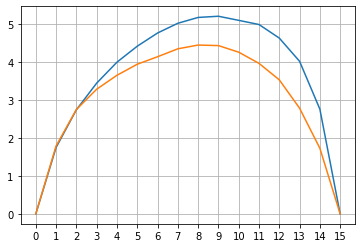

In [300]:
xs = range(agent_reward_spans.shape[1])
plt.xticks(xs)
plt.plot(reward_spans.mean(axis=0))
plt.plot(agent_reward_spans.mean(axis=0))
plt.grid()

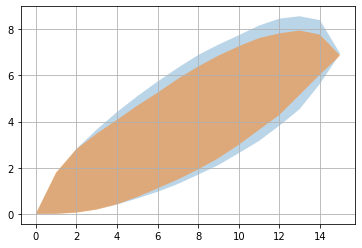

In [307]:
plt.fill_between(xs, reward_lower.mean(axis=0), reward_upper.mean(axis=0), alpha=0.3)
plt.fill_between(xs, agent_reward_lower.mean(axis=0), agent_reward_upper.mean(axis=0), alpha=0.5)
plt.grid()